In [1]:
# Solving the acoustic wave equation in 1D with zero Dirichlet boundary conditions
# Comparison of 6th order FD stencil and 4th order optimized FD stencil

In [2]:
# Import modules
%matplotlib notebook

from numpy import sin, cos, pi, linspace, shape
#import matplotlib.pyplot as plt

import numpy as np
from devito import Grid, Function, TimeFunction, Eq, Operator, solve, SpaceDimension
from devito import ConditionalDimension, Constant, first_derivative, second_derivative
from devito import left, right
from math import exp
from scipy.integrate import quad

import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Global constants
L = 10. # Define length of domain as a global variable
k = 100 # Number of terms in the Fourier sine series
l = 251 # Define number of points in domain

x_vals = linspace(0, L, l) # x axis for calling u(x, t) at given t

In [4]:
# Calculate exact solution

def square_init(x): # Square function to base Fourier series off of
    if x >= 0 and x < L/4.:
        return 1.
    elif x >= L/4. and x < L/2.:
        return -1.
    else:
        return 0.

def D_n_inner(x, n): # Inner part of D_n to allow for scipy.integrate.quad to be used
    return square_init(x)*sin(n*pi*x/L)
    
def D_n_calc(n): # Define function to calculate d_n for a given n
    if n % 2 == 0:
        return (4./L)*quad(D_n_inner, 0, L/2., args=(n))[0]
    else:
        return 0.

def u(x, t): # Analytic solution calculator
    u_temp = 0.
    
    for n in range(1, 2*k+1):
        u_temp += D_n_calc(n)*sin(n*pi*x/L)*cos(n*pi*t/L)
        
    return u_temp

In [5]:
# Conventional FD solution using Devito stencil

# Set up conventional FD parameters
so_dev = 6 # 6th order accurate in space
to_dev = 2 # 2nd order accurate in time


extent = (L,) # Grid is L long with l grid points
shape = (l,)

# dt is defined using Courant condition (c = 1)
# dt = 0.2*(L/(shape[0]-1)) # Timestep is half critical dt (0.0025)
# dt = 5e-4
dt = 0.2*L/(l-1)
t_end = 4*L # Standing wave will cycle twice in time L
ns = int(t_end/dt) # Number of timesteps = total time/timestep size

In [6]:
grid = Grid(shape=(l), extent=(L))
time = grid.time_dim
x = grid.dimensions[0]

# Set up function and stencil
u_dev = TimeFunction(name="u_dev", grid=grid, space_order=so_dev, time_order=to_dev, save=ns+1)

# Functions for initalizing standing square wave
def b_n_inner(x, n): # Inner part of b_n to allow for scipy.integrate.quad to be used
    return square_init(x)*sin(2.*n*pi*x/L)

def b_n_calc(n):
    return (4./L)*quad(b_n_inner, 0, L/2., args=(n))[0]
    
def u_init(x):
    u_temp = 0.
    for n in range(1, k+1):
        u_temp += b_n_calc(n)*sin(2.*n*pi*x/L)
        
    return u_temp

# Initialize wavefield
u_dev.data[:] = 0.1*u_init(linspace(0, L, u_dev.data.shape[1]))

eq_dev = Eq(u_dev.dt2-u_dev.dx2)
stencil_dev = solve(eq_dev, u_dev.forward)

bc_dev = [Eq(u_dev[time+1,0], 0.0)] # Specify boundary conditions
bc_dev += [Eq(u_dev[time+1,-1], 0.0)]

In [7]:
# Create operator
op_dev = Operator([Eq(u_dev.forward, stencil_dev)]+bc_dev)

# Apply operator
op_dev.apply(time_M=ns-1, dt=dt)

In [8]:
# Optimized FD solution

# Set up optimized FD parameters
so_opt = 4 # 6th order accurate in space
to_opt = 2 # 2nd order accurate in time
h_x = grid.spacing[0]



In [9]:
# Set up function and stencil
u_opt = TimeFunction(name="u_dev", grid=grid, space_order=so_opt, time_order=to_opt, save=ns+1)

# Initialize wavefield
u_opt.data[:] = 0.1*u_init(linspace(0, L, u_opt.data.shape[1]))

# Optimized stencil coefficients
a_0 = -2.81299833
a_1 = 1.56808208
a_2 = -0.17723283
a_3 = 0.01564992

eq_opt =  (a_3*u_opt[time, x - 3]
           + a_2*u_opt[time, x - 2]
           + a_1*u_opt[time, x - 1]
           + a_0*u_opt[time, x]
           + a_1*u_opt[time, x + 1]
           + a_2*u_opt[time, x + 2]
           + a_3*u_opt[time, x + 3])/h_x**2- u_opt.dt2

stencil_opt = solve(eq_opt, u_opt.forward)

bc_opt = [Eq(u_opt[time+1,0], 0.0)] # Specify boundary conditions
bc_opt += [Eq(u_opt[time+1,-1], 0.0)]

In [10]:
# Create operator
op_opt = Operator([Eq(u_opt.forward, stencil_opt)]+bc_opt)

# Apply operator
op_opt.apply(time_M=ns-1, dt=dt)

In [ ]:
fig = plt.figure()
plt.plot(x_vals, 0.1*u(x_vals, 0), 'k-', 
            label='Analytic solution', linewidth=0.75)

plt.plot(x_vals, u_dev.data[1], 'b-', 
            label='Conventional 6th order', linewidth=0.75)

plt.plot(x_vals, u_opt.data[1], 'r-', 
            label='Optimized 4th order', linewidth=0.75)
plt.ylim(-0.12, 0.12)
plt.title("Snapshot of wave at t = 0\n Courant number = %.2f; dx = %.4f" % (dt/(L/(shape[0]-1)), L/(l-1.)))
plt.xlabel("x (m)")
plt.ylabel("u (Pa)")
plt.legend(loc=1)
plt.savefig("Figures/Dx_0.0400/Wavefield_Snapshots/time0.00.png", dpi=200)
plt.show()

for i in linspace(0, t_end, (t_end*5.)+1.):
    if i == 0:
        continue
    fig = plt.figure()
    plt.plot(x_vals, 0.1*u(x_vals, float(i)), 'k-', 
            label='Analytic solution', linewidth=0.75)

    plt.plot(x_vals, u_dev.data[int(i*u_dev.data.shape[0]/t_end)-1], 'b-', 
            label='Conventional 6th order', linewidth=0.75)

    plt.plot(x_vals, u_opt.data[int(i*u_dev.data.shape[0]/t_end)-1], 'r-', 
            label='Optimized 4th order', linewidth=0.75)
    plt.ylim(-0.12, 0.12)
    plt.title("Snapshot of wave at t = %.2f\n Courant number = %.2f; dx = %.4f" 
              % (float(i), dt/(L/(shape[0]-1.)), L/(l-1)))
    plt.xlabel("x (m)")
    plt.ylabel("u (Pa)")
    plt.legend(loc=1)
    plt.savefig("Figures/Dx_0.0400/Wavefield_Snapshots/time%.2f.png" % (i), dpi=200)
    plt.show()


/home/ed/.local/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


<IPython.core.display.Javascript object>


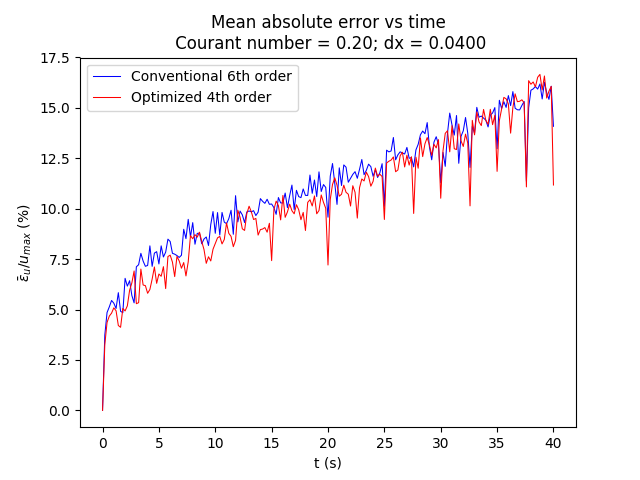

In [11]:
# Plot mean absolute error vs time
from numpy import mean

time_list = [0]
err_dev_list = [mean(abs(0.1*u(x_vals, 0)-u_dev.data[1]))]
err_opt_list = [mean(abs(0.1*u(x_vals, 0)-u_opt.data[1]))]

for i in linspace(0, t_end, (t_end*5.)+1.):
    if i == 0:
        continue
    time_list.append(i)
    err_dev_list.append(1000.*mean(abs(0.1*u(x_vals, float(i))-u_dev.data[int(i*u_dev.data.shape[0]/t_end)-1])))
    err_opt_list.append(1000.*mean(abs(0.1*u(x_vals, float(i))-u_opt.data[int(i*u_opt.data.shape[0]/t_end)-1])))
    
fig = plt.figure()
plt.plot(time_list, err_dev_list, 'b-', 
            label='Conventional 6th order', linewidth=0.75)

plt.plot(time_list, err_opt_list, 'r-', 
            label='Optimized 4th order', linewidth=0.75)
plt.title("Mean absolute error vs time\n Courant number = %.2f; dx = %.4f" % (dt/(L/(shape[0]-1)), L/(l-1.)))
plt.xlabel("t (s)")
plt.ylabel(r'$\bar\epsilon_u/u_{max}$ (%)')
plt.legend(loc=0)
plt.savefig("Figures/Dx_0.0400/mean_absolute_error", dpi=200)
plt.show()

In [ ]:
#Plot spectrums at each multiple of L/2
from numpy.fft import rfft

dx = L/(l-1)
f_vals = linspace(0, 0.5/dx, (l/2+1))

fig = plt.figure()
plt.plot(f_vals[:120], rfft(0.1*u(x_vals, 0), norm="ortho")[:120], 'k-', 
            label='Analytic solution', linewidth=0.75)

plt.plot(f_vals[:120], rfft(u_dev.data[1], norm="ortho")[:120], 'b-', 
            label='Conventional 6th order', linewidth=0.75)

plt.plot(f_vals[:120], rfft(u_opt.data[1], norm="ortho")[:120], 'r-', 
            label='Optimized 4th order', linewidth=0.75)
plt.title("Snapshot of wave spectrum at t = 0\n Courant number = %.2f; dx = %.4f" % (dt/(L/(shape[0]-1)), L/l))
plt.xlabel(r'$\alpha$ (cycles/m)')
plt.ylabel(r'$\~u$ (Pa)')
plt.ylim(-0.020, 0.020)
plt.tight_layout()
plt.legend(loc=1)
plt.savefig("Figures/Dx_0.0111/Spectrum_Snapshots/time0.00.png", dpi=200)
plt.show()

for i in linspace(0, t_end, (t_end*5.)+1.):
    if i == 0:
        continue
    fig = plt.figure()
    plt.plot(f_vals[:120], rfft(0.1*u(x_vals, float(i)), norm="ortho")[:120], 'k-', 
            label='Analytic solution', linewidth=0.75)

    plt.plot(f_vals[:120], rfft(u_dev.data[int(i*u_dev.data.shape[0]/t_end)-1], norm="ortho")[:120], 'b-', 
            label='Conventional 6th order', linewidth=0.75)

    plt.plot(f_vals[:120], rfft(u_opt.data[int(i*u_dev.data.shape[0]/t_end)-1], norm="ortho")[:120], 'r-', 
            label='Optimized 4th order', linewidth=0.75)
    plt.title("Snapshot of wave spectrum at t = %.2f\n Courant number = %.2f; dx = %.4f" % (float(i), dt/(L/(shape[0]-1)), L/l))
    plt.xlabel(r'$\alpha$ (cycles/m)')
    plt.ylabel(r'$\~u$ (Pa)')
    plt.ylim(-0.020, 0.020)
    plt.tight_layout()
    plt.legend(loc=1)
    plt.savefig("Figures/Dx_0.0111/Spectrum_Snapshots/time%.2f.png" % (i), dpi=200)
    plt.show()

In [ ]:
# Plot mean absolute frequency error vs time
from numpy import mean
from numpy.fft import rfft

time_list = [0]
err_dev_list = [mean(abs(rfft(0.1*u(x_vals, 0), norm="ortho")-rfft(u_dev.data[1], norm="ortho")))]
err_opt_list = [mean(abs(rfft(0.1*u(x_vals, 0), norm="ortho")-rfft(u_opt.data[1], norm="ortho")))]

for i in linspace(0, t_end, (t_end*5.)+1.):
    if i == 0:
        continue
    time_list.append(i)
    err_dev_list.append(mean(abs(rfft(0.1*u(x_vals, float(i)), norm="ortho")
                                 -rfft(u_dev.data[int(i*u_dev.data.shape[0]/t_end)-1], norm="ortho"))))
    err_opt_list.append(mean(abs(rfft(0.1*u(x_vals, float(i)), norm="ortho")
                                 -rfft(u_opt.data[int(i*u_opt.data.shape[0]/t_end)-1], norm="ortho"))))
    
fig = plt.figure()
plt.plot(time_list, err_dev_list, 'b-', 
            label='Conventional 6th order', linewidth=0.75)

plt.plot(time_list, err_opt_list, 'r-', 
            label='Optimized 4th order', linewidth=0.75)
plt.title("Mean absolute spectral error vs time\n Courant number = %.2f; dx = %.4f" % (dt/(L/(shape[0]-1)), L/l))
plt.xlabel("t (s)")
plt.ylabel(r'$\bar\epsilon_\~u$ (Pa)')
plt.legend(loc=0)
plt.savefig("Figures/Dx_0.0111/mean_absolute_spectral_error", dpi=200)
plt.show()

In [12]:
from numpy import mean
print("Mean absolute error at t_end for conventional", mean(abs(0.1*u(x_vals, t_end)-u_dev.data[-2])))
print("Mean absolute error at t_end for optimized", mean(abs(0.1*u(x_vals, t_end)-u_opt.data[-2])))

Mean absolute error at t_end for conventional 0.014678290952583568
Mean absolute error at t_end for optimized 0.011997922078787472
